# 2018-12-13 - Using grid search to automate scans
En fait ça va pas le faire, il faut que j'augmente la cadence du scan avec du grid search, donc faut projeter un array mutlidimensionnel en plat et itérer la dessus, avec une métrique de fit pour visualiser le rapport à la fin.

# Metrique de précision
Soit le sigma de la courbe final,

soit le delta sigma entre la première séquence et la dernière (mais on peut donc être deux fois nul et ça fera rien), 

soit un score composé des deux ?

L'ouverture de début renseigne sur la manière dont le système s'adapte au bruit, l'ouvert de fin renseigne sur la manière dont il a appris et le delta est la capacité entre les deux.

# TODO 
améliorer la visualisation

# Init

In [2]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import lmfit
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/.local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DictError in SLIInterpreter::execute: Key '/Install' does not exist in dictionary.
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


# Testing the matrix creation
Turns out there's a builtin function in sk

In [2]:
from sklearn.model_selection import ParameterGrid
parameters_dico = {'sparseness': np.linspace(0, 1, 10),
                   'weight_mu': np.linspace(0.001, 2, 10),
                   'delays_mu': np.linspace(1, 5, 10)}

grid = ParameterGrid(parameters_dico)

In [3]:
list(grid)

[{'delays_mu': 1.0, 'sparseness': 0.0, 'weight_mu': 0.001},
 {'delays_mu': 1.0, 'sparseness': 0.0, 'weight_mu': 0.22311111111111112},
 {'delays_mu': 1.0, 'sparseness': 0.0, 'weight_mu': 0.44522222222222224},
 {'delays_mu': 1.0, 'sparseness': 0.0, 'weight_mu': 0.6673333333333333},
 {'delays_mu': 1.0, 'sparseness': 0.0, 'weight_mu': 0.8894444444444445},
 {'delays_mu': 1.0, 'sparseness': 0.0, 'weight_mu': 1.1115555555555554},
 {'delays_mu': 1.0, 'sparseness': 0.0, 'weight_mu': 1.3336666666666666},
 {'delays_mu': 1.0, 'sparseness': 0.0, 'weight_mu': 1.5557777777777777},
 {'delays_mu': 1.0, 'sparseness': 0.0, 'weight_mu': 1.7778888888888889},
 {'delays_mu': 1.0, 'sparseness': 0.0, 'weight_mu': 2.0},
 {'delays_mu': 1.0, 'sparseness': 0.1111111111111111, 'weight_mu': 0.001},
 {'delays_mu': 1.0,
  'sparseness': 0.1111111111111111,
  'weight_mu': 0.22311111111111112},
 {'delays_mu': 1.0,
  'sparseness': 0.1111111111111111,
  'weight_mu': 0.44522222222222224},
 {'delays_mu': 1.0,
  'sparseness':

In [4]:
def ultra_complex_function(sparseness, weight_mu, delays_mu):
    print(sparseness, weight_mu, delays_mu)

In [5]:
for param in grid:
    ultra_complex_function(param['sparseness'],
                           param['weight_mu'], param['delays_mu'])

0.0 0.001 1.0
0.0 0.22311111111111112 1.0
0.0 0.44522222222222224 1.0
0.0 0.6673333333333333 1.0
0.0 0.8894444444444445 1.0
0.0 1.1115555555555554 1.0
0.0 1.3336666666666666 1.0
0.0 1.5557777777777777 1.0
0.0 1.7778888888888889 1.0
0.0 2.0 1.0
0.1111111111111111 0.001 1.0
0.1111111111111111 0.22311111111111112 1.0
0.1111111111111111 0.44522222222222224 1.0
0.1111111111111111 0.6673333333333333 1.0
0.1111111111111111 0.8894444444444445 1.0
0.1111111111111111 1.1115555555555554 1.0
0.1111111111111111 1.3336666666666666 1.0
0.1111111111111111 1.5557777777777777 1.0
0.1111111111111111 1.7778888888888889 1.0
0.1111111111111111 2.0 1.0
0.2222222222222222 0.001 1.0
0.2222222222222222 0.22311111111111112 1.0
0.2222222222222222 0.44522222222222224 1.0
0.2222222222222222 0.6673333333333333 1.0
0.2222222222222222 0.8894444444444445 1.0
0.2222222222222222 1.1115555555555554 1.0
0.2222222222222222 1.3336666666666666 1.0
0.2222222222222222 1.5557777777777777 1.0
0.2222222222222222 1.7778888888888889

# Ok now let's get scanning
Some functions are modified, careful if copying this notebook

In [6]:
def fit_gaussian(popsize, spike_array, seq_nbr=None):
    '''
    calculates a spike array gaussian lmfit profile and plots it
    '''
    # fit the gaussian
    x = np.linspace(0, popsize, popsize)
    y = spike_array

    mod = GaussianModel()
    pars = mod.guess(y, x=x)

    out = mod.fit(y, pars, x=x)
    # print(out.fit_report())
    # eye cancer-triggering lines
    sigma = out.best_values['sigma']

    return sigma


def tuning_function(i, j, B, N):  # von mises
    if B == np.inf:
        VM = np.ones_like(i*j)
    else:
        VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
    VM /= VM.sum(axis=0)
    return VM


def cut_spiketrain(array, window):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype=float)

        spiketrain_cut = np.where(
            (spiketrain_array > window*500) & (spiketrain_array < (window+1)*500))[0]

        spiketrain_len.append(len(spiketrain_cut))

    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

In [7]:
def SuperScanner(SpikesP, SpikesE, SpikesI,
                 popsize, rates, simtime):

    sigma_zero = fit_gaussian(popsize, cut_spiketrain(SpikesE, 0), seq_nbr=1)
    sigma_one = fit_gaussian(popsize, cut_spiketrain(SpikesE, 1), seq_nbr=2)
    sigma_two = fit_gaussian(popsize, cut_spiketrain(SpikesE, 2), seq_nbr=3)
    sigma_f = fit_gaussian(popsize, cut_spiketrain(SpikesE, 3), seq_nbr=4)

    return [sigma_zero, sigma_one, sigma_two, sigma_f]

# Hyperparameters

In [8]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 2000
rng = sim.NumpyRNG(seed=42)

rate_gain = 10.  # multiplier for the rates
angle_input = 40  # degrees
b_theta = 30  # degrees
sparseness = .1

# Grid search, rerunning the STDP example
Only looking for the temporal aspects

In [9]:
from sklearn.model_selection import ParameterGrid

scan_size = 4
parameters_dico = {'sparseness': np.array([.1]), #if we already know a nice param we can array it
                   'weight_mu': np.array([1.5]),
                   'delays_mu': np.linspace(1, 5, scan_size),
                   'taus': np.linspace(5, 60, scan_size),
                   'stdp_amps': np.linspace(.1, 6, scan_size),
                   'stdp_weight_init': np.array([.5]),
                   'stdp_max_weight': np.array([1]),
                   'ratio_weights_EI': np.linspace(.1, 10, scan_size),
                   'ratio_amps': np.linspace(.1, 10, scan_size),
                   'ratio_taus': np.linspace(.1, 10, scan_size)}

# ratio multiply the negative part of the duo, ie inhibition, tau minus and A minus

grid = ParameterGrid(parameters_dico)

In [10]:
import datetime

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d-%Hh%M")

# a+ to append and create if not existant
f = open("./output/scan_logs_%s.txt" % strtime, "a+")
f.write('SCANNING PARAMETERS @ '+strtime)
f.close()

In [11]:
def run_simulation(sparseness, weight_mu, delays_mu,
                   tau, stdp_amp, stdp_weight_init, stdp_max_weight,
                   ratio_weights_EI, ratio_amps, ratio_taus,
                   filewrite, full_args):

    def vary_angle(t):
        simtime = 2000
        n_pop = 60
        shift = 40

        angle = 1. * np.arange(n_pop)
        rates = tuning_function(
            angle, (t*shift)+(angle_input)/180.*n_pop, b_theta, n_pop)
        rates /= rates.mean()
        rates *= rate_gain
        for i, cell in enumerate(input_pop):
            cell.set_parameters(rate=rates[i])
        return t + simtime/4

    # WEIGHTS
    normal_weights = rnd('normal_clipped', mu=weight_mu, sigma=.2, low=0.1,
                         high=5,
                         rng=rng)
    inh_normal_weights = rnd('normal_clipped', mu=weight_mu*ratio_weights_EI, sigma=.2, low=0.1,
                             high=5,
                             rng=rng)

    # DELAYS
    delays = rnd('normal_clipped', mu=delays_mu, sigma=.2, low=0.1,
                 high=5,
                 rng=rng)

    # STDP
    timing_dependence = sim.SpikePairRule(tau_plus=tau, tau_minus=tau*ratio_taus,
                                          A_plus=stdp_amp, A_minus=stdp_amp*ratio_amps)

    sim.setup(timestep=.1, threads=8)

    # POPULATIONS
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Exictateurs")

    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop,
                               sim.SpikeSourcePoisson(
                                   rate=500, duration=simtime, start=250),
                               label="Entree Orientation")

    stabilizing_pop = sim.Population(n_pop,
                                     sim.SpikeSourcePoisson(
                                         rate=10, duration=200, start=0),
                                     label="Entree Orientation")

    # SYNAPSES
    STDP_syn = sim.STDPMechanism(
        timing_dependence=timing_dependence,
        weight_dependence=sim.AdditiveWeightDependence(
            w_min=0, w_max=stdp_max_weight),
        weight=stdp_weight_init,
        delay=delays,
        dendritic_delay_fraction=1.)

    # Intras
    syn_exc_exc = sim.Projection(exc, exc,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_inh = sim.Projection(inh, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=sim.StaticSynapse(
                                     weight=normal_weights, delay=delays),
                                 receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

    # Inters
    syn_exc_inh = sim.Projection(exc, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_ex = sim.Projection(inh, exc,
                                connector=sim.FixedProbabilityConnector(
                                    sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(
                                    weight=normal_weights, delay=delays),
                                receptor_type='inhibitory')

    # Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                 connector=sim.OneToOneConnector(),
                                 synapse_type=sim.StaticSynapse(
                                     weight=1, delay=1),
                                 receptor_type='excitatory')
    sin_stab_exc = sim.Projection(stabilizing_pop, exc,
                                  connector=sim.OneToOneConnector(),
                                  synapse_type=sim.StaticSynapse(
                                      weight=1, delay=1),
                                  receptor_type='excitatory')

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime, callbacks=[vary_angle])
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    scan_lst = SuperScanner(SpikesP=inp_data, SpikesE=exc_data, SpikesI=inh_data,
                            popsize=60, rates=rates, simtime=2000)

    # logging
    f = open(filewrite, "a+")
    f.write('\nSigmas\n')
    f.write(str(scan_lst))
    f.write('\nParams\n')
    f.write(str(full_args))
    f.write('\n\n')
    f.close()

    sim.reset()
    return scan_lst, full_args

In [12]:
import datetime
from tqdm import tqdm

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d-%Hh%M")

scan_output = []
for combination in tqdm(grid):
    sigmas, args = run_simulation(sparseness=combination['sparseness'],
                                  weight_mu=combination['weight_mu'],
                                  delays_mu=combination['delays_mu'],
                                  tau=combination['taus'],
                                  stdp_amp=combination['stdp_amps'],
                                  stdp_weight_init=combination['stdp_weight_init'],
                                  stdp_max_weight=combination['stdp_max_weight'],
                                  ratio_weights_EI=combination['ratio_weights_EI'],
                                  ratio_amps=combination['ratio_amps'],
                                  ratio_taus=combination['ratio_taus'],
                                  filewrite='./output/scan_logs_%s.txt' % strtime,
                                  full_args=combination)
    scan_output.append([sigmas, args])

100%|██████████| 4096/4096 [1:50:20<00:00,  1.92s/it]


In [13]:
scan_output = np.asarray(scan_output)

np.save('./output/scan_results_%s.npy' % strtime,
        scan_output)

In [3]:
#scan_output = np.load('./output/scan_results_2018-12-16-19h31.npy')

In [72]:
sigmas_zero, sigmas_f, delta_sigmas = [],[],[]
for scan in scan_output :
    sigmas = scan[0]
    sigma_zero = sigmas[0]
    sigma_f = sigmas[-1]
    delta_sigma = sigma_zero - sigma_f
    
    sigmas_zero.append(sigma_zero)
    sigmas_f.append(sigma_f)
    delta_sigmas.append(delta_sigma)
    
sigmas_zero = np.asarray(sigmas_zero)
sigmas_f = np.asarray(sigmas_f)
delta_sigmas = np.asarray(delta_sigmas)

(0, 300)

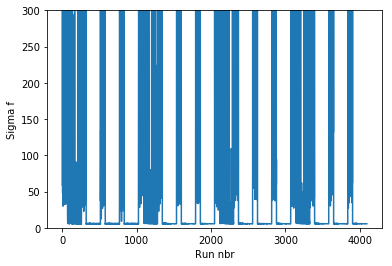

In [73]:
plt.plot(sigmas_f)
plt.ylabel('Sigma f')
plt.xlabel('Run nbr')
plt.ylim(0, 300)

Text(0.5,1,'On veut les petits points en bas a gauche')

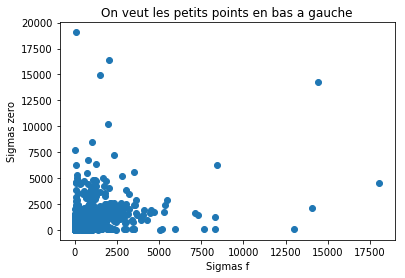

In [74]:
plt.scatter(sigmas_f, sigmas_zero)
plt.xlabel('Sigmas f')
plt.ylabel('Sigmas zero')
plt.title('On veut les petits points en bas a gauche')

Text(0.5,1,'Visualisation orthogonale, on veut toujours en bas à gauche')

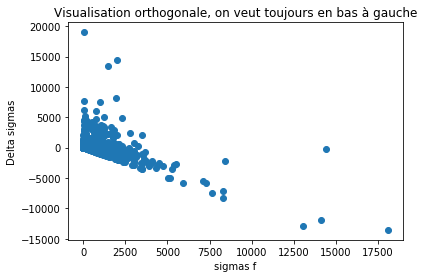

In [75]:
plt.scatter(sigmas_f, delta_sigmas)
plt.xlabel('sigmas f')
plt.ylabel('Delta sigmas')
plt.title('Visualisation orthogonale, on veut toujours en bas à gauche')

In [76]:
np.where(np.asarray(sigmas_zero) < 100)

(array([   0,    3,    5, ..., 4093, 4094, 4095]),)

In [77]:
z.shape

(4077,)

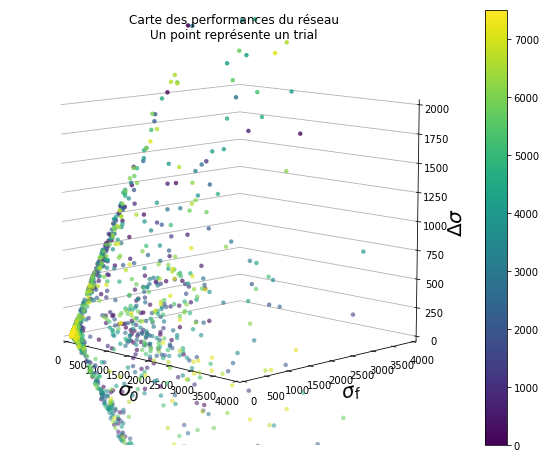

In [78]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

vislim = 4000

# un peu de masking
sigmas_zero[sigmas_zero > vislim] = np.nan
sigmas_f[sigmas_f > vislim] = np.nan
delta_sigmas[delta_sigmas > vislim] = np.nan


tri = ax.scatter3D(sigmas_zero,
                   sigmas_f,
                   delta_sigmas,
                   c=np.linspace(0, 7500, 4096),
                   cmap=plt.cm.viridis,
                   linewidth=0)

ax.set_zlabel('$\Delta$$\sigma$', fontsize=20)
ax.set_xlabel('$\sigma_0$', fontsize=20)
ax.set_ylabel('$\sigma_f$', fontsize=20)

ax.xaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
ax.yaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
#ax.zaxis._axinfo["grid"]["color"] = (1,1,1,0)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))


ax.set_xlim(0, vislim)
ax.set_ylim(0, vislim)
ax.set_zlim(0, vislim/2)
plt.colorbar(tri)
ax.set_title('Carte des performances du réseau\nUn point représente un trial')
ax.view_init(azim=-45, elev=10)